<a href="https://colab.research.google.com/github/ezoizy/Mineral_Model/blob/master/Capstone_Project_Acc_68_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import seaborn as sns
import shutil
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [ ]:
!kaggle datasets download -d asiedubrempong/minerals-identification-dataset

 97% 224M/230M [00:02<00:00, 97.0MB/s]
100% 230M/230M [00:02<00:00, 109MB/s] 


In [ ]:
import os
import zipfile

local_zip = 'minerals-identification-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('minerals_identification')
local_zip = 'minerals-identification-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('minerals_identification')
zip_ref.close()
print('done')

done


In [ ]:
biotite_dir=r'minerals_identification/minet/biotite'
bornite_dir=r'minerals_identification/minet/bornite'
chrysocolla_dir=r'minerals_identification/minet/chrysocolla'
malachite_dir=r'minerals_identification/minet/quartz'
muscovite_dir=r'minerals_identification/minet/muscovite'
pyrite_dir=r'minerals_identification/minet/pyrite'
quartz_dir=r'minerals_identification/minet/quartz'
dirlist=[biotite_dir,bornite_dir,chrysocolla_dir,malachite_dir,muscovite_dir,pyrite_dir,quartz_dir]
classes=['biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite','pyrite','quartz']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  866    labels:  866


In [ ]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)

balance=df['labels'].value_counts()
print (balance)

bornite        173
chrysocolla    164
malachite      143
quartz         143
pyrite          98
muscovite       77
biotite         68
Name: labels, dtype: int64


In [ ]:
out_dir=r'./'  
aux_dir_path=os.path.join(out_dir, 'Aux')
if os.path.isdir(aux_dir_path)== False:
    os.mkdir(aux_dir_path)
else:
    shutil.rmtree(aux_dir_path)
    os.mkdir(aux_dir_path)
biotite_path=os.path.join(aux_dir_path, 'biotite')
os.mkdir(biotite_path)
muscovite_path=os.path.join(aux_dir_path, 'muscovite')
os.mkdir(muscovite_path)
print(os.listdir(aux_dir_path))
under_classes=[biotite_dir, muscovite_dir]
biotite_array=np.zeros((86,224,224,3))                      
muscovite_array=np.zeros((101,224,224,3))  
for d in under_classes:
    if d==biotite_dir:
        darray=biotite_array
        dpath=biotite_path
        batch_size=86
    else:
        darray=muscovite_array
        dpath=muscovite_path
        batch_size=101
    flist=os.listdir(d)
    for i, f in enumerate(flist):
        fpath=os.path.join(d,f)
        img=cv2.imread(fpath)
        img=cv2.resize(img,(224,224))
        darray[i]=img
    gen=ImageDataGenerator( horizontal_flip=True, rotation_range=30, zoom_range=.2,
                          height_shift_range=.2, width_shift_range=.2).flow(darray, batch_size=batch_size, shuffle=True, save_to_dir=dpath, )
    next(gen)
    next(gen)
biotite_list=os.listdir(biotite_path)
muscovite_list=os.listdir(muscovite_path)
print (len(biotite_list), '  ', len(muscovite_list))

['biotite', 'muscovite']
172    202


In [ ]:
labels=[]
filepaths=[]
sdir=aux_dir_path
slist=os.listdir(sdir)
for klass in slist:
    class_path=os.path.join(sdir, klass)
    flist=os.listdir(class_path)
    for f in flist:
        fpath=os.path.join(class_path,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
aux_df=pd.concat([Fseries, Lseries], axis=1)
print(aux_df.head())
print(aux_df['labels'].value_counts())
print('len of df: ', len(df), '  len of aux_df: ', len(aux_df))
df=pd.concat([df,aux_df], axis=0).reset_index(drop=True)
print (len(df))
print(df['labels'].value_counts())

                    filepaths   labels
0  ./Aux/biotite/_42_3361.png  biotite
1   ./Aux/biotite/_72_931.png  biotite
2  ./Aux/biotite/_55_8965.png  biotite
3   ./Aux/biotite/_6_9509.png  biotite
4  ./Aux/biotite/_40_2165.png  biotite
muscovite    202
biotite      172
Name: labels, dtype: int64
len of df:  866   len of aux_df:  374
1240
muscovite      279
biotite        240
bornite        173
chrysocolla    164
malachite      143
quartz         143
pyrite          98
Name: labels, dtype: int64


In [ ]:
height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print (len(train_df), len(test_df), len(valid_df))
vcounts=train_df['labels'].value_counts()
print (vcounts)
vmin=np.min(list(vcounts))

992 124 124
muscovite      218
biotite        198
chrysocolla    131
bornite        129
quartz         124
malachite      119
pyrite          73
Name: labels, dtype: int64


In [ ]:
file_count = vmin
samples = []
for category in train_df['labels'].unique():    
    category_slice = train_df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
train_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  train_df['labels'].value_counts()) # check to see each class has 200 samples
print (len(train_df))

muscovite      73
biotite        73
malachite      73
chrysocolla    73
quartz         73
bornite        73
pyrite         73
Name: labels, dtype: int64
511


In [ ]:
import random
random = random.randint(0,600)

In [ ]:
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 507 validated image filenames belonging to 7 classes.
Found 123 validated image filenames belonging to 7 classes.
Found 123 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(len(classes), activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

219062272/219055592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(255,0,0)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(255,0,0)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [ ]:
epochs =20
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

 Starting training using base model InceptionResNetV2 training all layers 



In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /20     9.462   46.746  16.91270  42.276   0.00100  0.00100  accuracy   70.63  

 2 /20     8.273   69.625  18.24083  43.902   0.00100  0.00100  accuracy   13.36  

 3 /20     7.600   81.065  31.69601  37.398   0.00100  0.00100  accuracy   13.48  

 4 /20     7.102   86.982  18.34362  43.089   0.00100  0.00100  accuracy   13.51  

 5 /20     6.758   86.785  13.31655  41.463   0.00100  0.00050  accuracy   13.57  

 6 /20     6.510   90.533   9.63021  46.341   0.00050  0.00050  val_loss   13.51  

 7 /20     6.386   91.519   7.71104  59.350   0.00050  0.00050  val_loss   13.51  

 8 /20     6.251   92.110   7.34078  60.163   0.00050  0.00050  val_loss   13.38  

 9 /20     6.132   91.913   7.05465  60.163   0.00050  0.00050  val_loss   13.39  

10 /20     6.011   94.477   6.83411  58.537   0.00050  0.00050  val_loss   13.40  

11 /20     5.902   94.477   6.62793  63.415   0.00050  0.00050  val_loss   1

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

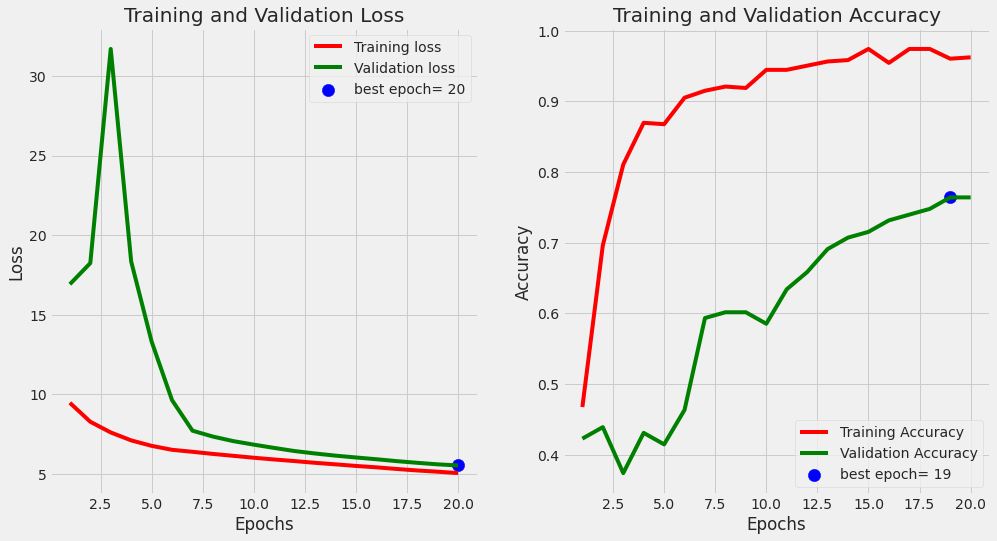

In [ ]:
tr_plot(history, 0)

In [ ]:
acc=model.evaluate(test_gen, verbose=1)[1]*100
print (' Accuracy on test set: ', acc)

3/3 [==============================] - 2s 416ms/step - loss: 5.6491 - accuracy: 0.7073
 Accuracy on test set:  70.7317054271698


In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
save_dir=r'./'
subject='rocks'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

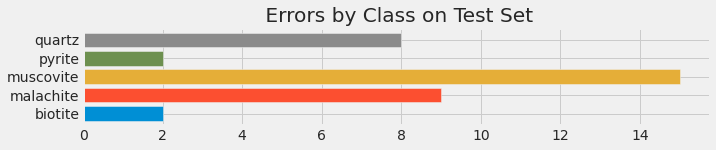

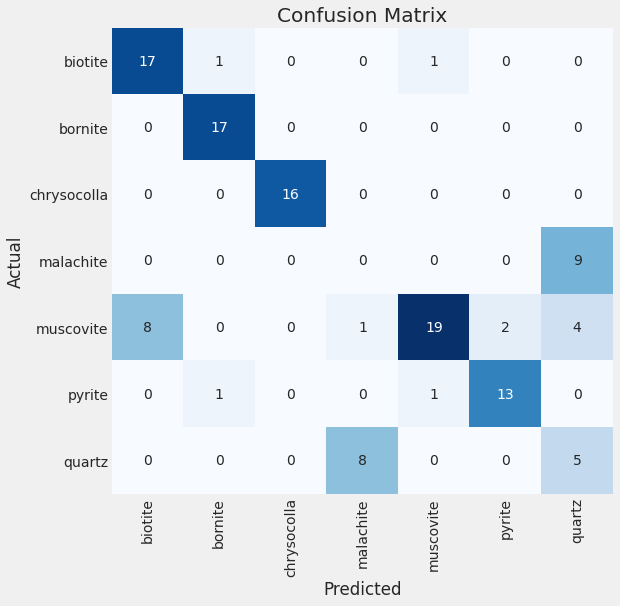

Classification Report:
----------------------
               precision    recall  f1-score   support

     biotite       0.68      0.89      0.77        19
     bornite       0.89      1.00      0.94        17
 chrysocolla       1.00      1.00      1.00        16
   malachite       0.00      0.00      0.00         9
   muscovite       0.90      0.56      0.69        34
      pyrite       0.87      0.87      0.87        15
      quartz       0.28      0.38      0.32        13

    accuracy                           0.71       123
   macro avg       0.66      0.67      0.66       123
weighted avg       0.74      0.71      0.71       123



In [ ]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )

In [ ]:
import tensorflow as tf
 
model = tf.keras.models.load_model(save_id)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("mineral_model.tflite", "wb").write(tflite_model)

NameError: ignored

In [ ]:
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path,target_size=(224,224,3))
  img = image.img_to_array(img)
  img = img/255

chrysocolla (0.791)
bornite (0.113)
malachite (0.0314)


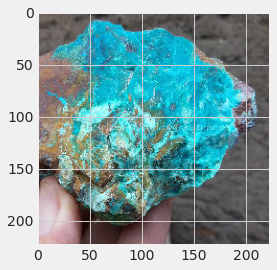

In [ ]:
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

In [ ]:
pred = np.argsort(proba[0])[-1]
print("prediksi mineral : ",classes[pred])
plt.imshow(img)

In [ ]:
io_type = tf.uint8 # or tf.uint8

In [ ]:
import tensorflow as tf
keras_model = tf.keras.models.load_model(save_id)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
image_shape=(224,224,3)
def representative_dataset_gen():
    for i in range(10):
        # creating fake images
        image = tf.random.normal([1] + list(image_shape))
        yield [image]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_cn3ig05/assets


In [ ]:
open("mineraluint8.tflite", "wb").write(tflite_quant_model) 

56897808

In [ ]:
def evaluate_model(tflite_file, model_type):
  global test_gen
  global classes

  test_image_indices = range(test_gen.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(classes== predictions) * 100) / len(test_gen

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_gen)))

In [ ]:
evaluate_model(tflite_quant_model, model_type="Quantized")

AttributeError: ignored